In [66]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# Import custom modules
from lib.FramesDataset import FramesDataset
from lib import network

# Global variables
WARMUP = 4
T_STEPS = 45
FRAME_SIZE = 20
HIDDEN_UNITS = 400
PATH = './models/model-2000epochs-400units-0.0003lr-0.25gradclip-1e-05L1-20210210-115130'

# Set device to use on network
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", DEVICE)

# Load previously trained model (2000 epochs)
model = network.RecurrentTemporalPrediction.load(
    hidden_units = HIDDEN_UNITS,
    frame_size = FRAME_SIZE,
    warmup = WARMUP,
    path = PATH + '.pt'
)

Using cpu


In [10]:
# Load dataset
train_dataset = FramesDataset('./processed_dataset.pkl', 'train', WARMUP)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
print("Training dataset length:", len(train_dataset))

Training dataset length: 28


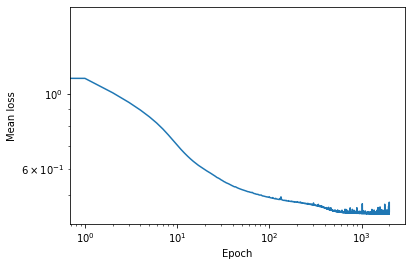

In [33]:
with open(PATH + '.pickle', 'rb') as p:
    loss_history = pickle.load(p)
    
plt.loglog(loss_history);
plt.xlabel('Epoch')
plt.ylabel('Mean loss')
plt.show()

In [46]:
n_rand_stimuli = 25000
activation_threshold = 0

stimuli = {}
for i in range(HIDDEN_UNITS):
    stimuli[i] = []

for i in range(n_rand_stimuli):
    if i % 1000 == 0:
        print('Trial %i' % i)
    
    noise_shape = (1, WARMUP+T_STEPS, FRAME_SIZE**2)
    noise = np.random.normal(loc=0, scale=1, size=noise_shape)
    noise = torch.Tensor(noise).to(DEVICE)
    
    _, hidden_state = model(noise)

    units = hidden_state[0, 0, :] # Discard first batch dimension
    for i, unit in enumerate(units):
        if unit > activation_threshold:
            #for stimulus_n in range(WARMUP+T_STEPS):
            stimuli[i].append(noise[0, -1, :].cpu().detach().numpy())

averaged_stimuli = {}
for i in range(HIDDEN_UNITS):
    stimuli_len = len(stimuli[i])
    if stimuli_len:
        averaged_stimuli[i] = np.stack(stimuli[i])
        averaged_stimuli[i] = np.reshape(np.mean(stimuli[i], 0), (FRAME_SIZE, FRAME_SIZE))

Trial 0
Trial 1000
Trial 2000
Trial 3000
Trial 4000
Trial 5000
Trial 6000
Trial 7000
Trial 8000
Trial 9000
Trial 10000
Trial 11000
Trial 12000
Trial 13000
Trial 14000
Trial 15000
Trial 16000
Trial 17000
Trial 18000
Trial 19000
Trial 20000
Trial 21000
Trial 22000
Trial 23000
Trial 24000


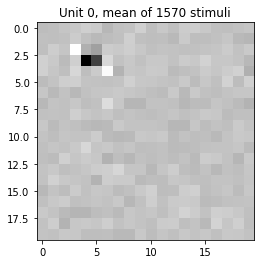

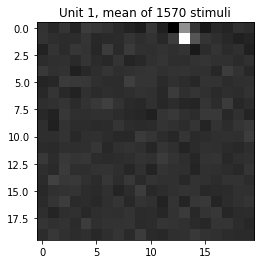

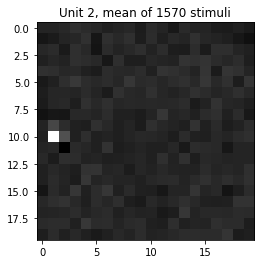

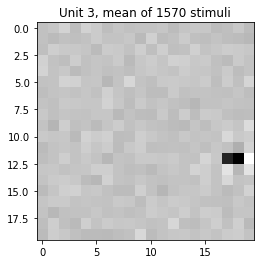

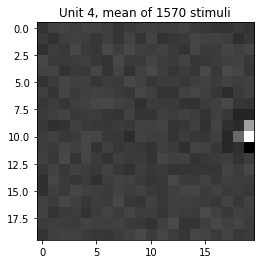

In [82]:
count = 0
total_count = 5

for i, key in enumerate(averaged_stimuli):
    count += 1
    if count > total_count:
        break
    
    plt.imshow(averaged_stimuli[i], cmap='gray')
    plt.title('Unit %i, mean of %i stimuli' % (i, stimuli_len))
    plt.show()

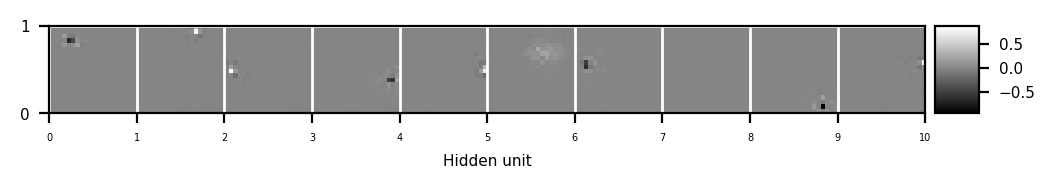

In [78]:
# Plot weights of input to recurrent layer
def plot_input_weights (model, hidden_units, frame_size):
    offset = 0
    
    weights = model.rnn.weight_ih_l0.cpu().detach().numpy()    
    weights = weights[:hidden_units+offset, :]
    
    im = np.zeros((frame_size, frame_size*hidden_units))
    for i in range(hidden_units):
        hidden_unit_weights = weights[i]
        im[:, i*frame_size:(i+1)*frame_size] = np.reshape(hidden_unit_weights, (frame_size, frame_size))
    
    font_size = 5.5
    font_size_title = 6
    
    fig, ax = plt.subplots(dpi=200)
    im_plt = plt.imshow(im, extent=[0, hidden_units, 0, 1], cmap='gray')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb_plt = plt.colorbar(im_plt, cax=cax)
    cb_plt.ax.tick_params(labelsize=font_size)
    
    ax.set_xticks(np.arange(0, hidden_units+1))
    ax.set_xticklabels(np.arange(0, hidden_units+1), size=font_size-2)
    ax.set_xlabel('Hidden unit', size=font_size)
    
    ax.set_yticks(np.arange(0, 2))
    ax.set_yticklabels(np.arange(0, 2), size=font_size)    
    
    ax.grid(which='major', color='w', linestyle='-', linewidth=1)
    
plot_input_weights(model, hidden_units = 10, frame_size = FRAME_SIZE)

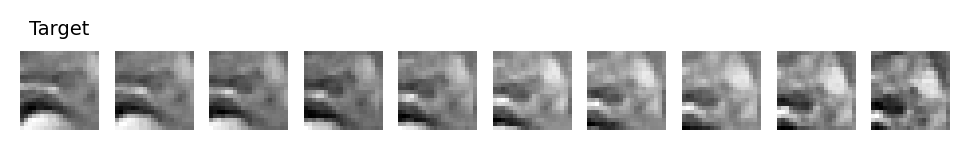

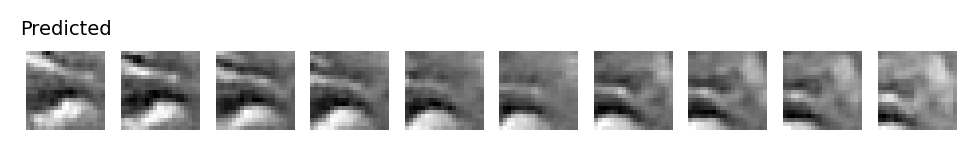

In [6]:
# Visualise network predictions
x, y = train_dataset[0]
x = x.to(DEVICE)
y = y.to(DEVICE)
pred, _ = model(torch.unsqueeze(x, 0))
pred = torch.squeeze(pred, 0)

steps = 10

fig, axes = plt.subplots(1, steps, dpi=200)
for i in range(steps):
    im_y = y[WARMUP+i].view(20, 20).detach().cpu().numpy()
    axes[i].imshow(im_y, cmap='gray')
    axes[i].axis('off')
axes[0].set_title('Target', size=7)
plt.show()

fig, axes = plt.subplots(1, steps, dpi=200)
for i in range(steps):
    im_pred = pred[i].view(20, 20).detach().cpu().numpy()
    axes[i].imshow(im_pred, cmap='gray')
    axes[i].axis('off')
axes[0].set_title('Predicted', size=7)
plt.show()